In [108]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(my_query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(my_query, conn)

def run_command(my_command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(my_command)

def show_tables():
    return run_query("SELECT name, type FROM sqlite_master WHERE type IN ('table','view');")

In [4]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [5]:
q = """
WITH usa AS
    (
        SELECT il.* FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE c.country = 'USA'
    )

SELECT
    g.name genre,
    COUNT(usa.invoice_line_id) tracks_sold,
    CAST(COUNT(usa.invoice_line_id) as FLOAT) /
        (SELECT COUNT(1) FROM usa) percentage
FROM usa
INNER JOIN track t ON t.track_id = usa.track_id
INNER JOIN genre g on t.genre_id = g.genre_id
GROUP BY genre
ORDER BY percentage DESC
"""
run_query(q)

,genre,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


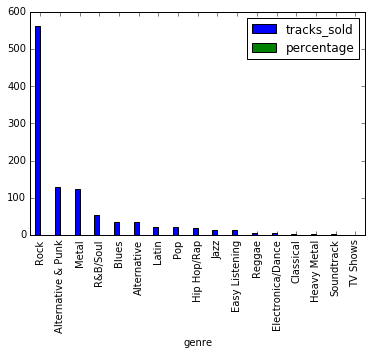

In [6]:
genre_data = run_query(q)
genre_data.set_index('genre', inplace=True)
genre_data.plot.bar()



In [5]:
query = """
SELECT e.first_name || " " || e.last_name employee_name,
    SUM(i.total) earned,
    i.billing_country,
    e.title
FROM employee e
LEFT JOIN customer c ON e.employee_id = c.support_rep_id
LEFT JOIN invoice i ON i.customer_id = c.customer_id

GROUP BY employee_name

"""

run_query(query)

,employee_name,earned,billing_country,title
0,Andrew Adams,NaN,None,General Manager
1,Jane Peacock,1731.51,India,Sales Support Agent
2,Laura Callahan,NaN,None,IT Staff
3,Margaret Park,1584.00,Argentina,Sales Support Agent
4,Michael Mitchell,NaN,None,IT Manager
5,Nancy Edwards,NaN,None,Sales Manager
6,Robert King,NaN,None,IT Staff
7,Steve Johnson,1393.92,Chile,Sales Support Agent


In [140]:
q = """
WITH 
invoice_first_track AS 
(
    SELECT
        t.track_id,
        i.invoice_id,
        a.album_id
    FROM
        track t
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN album a ON a.albuM_id = t.album_id
    GROUP BY i.invoice_id
),
full_album AS
(

    SELECT
        t.track_id,
        a.album_id
    FROM album a
    INNER JOIN track t ON a.album_id = t.album_id
)

SELECT
    is_album,
    count(*)
FROM
    (SELECT
        ifs.*,
        CASE
            WHEN (            
                SELECT f.track_id FROM full_album f
                WHERE f.album_id = ifs.album_id
            EXCEPT            
                SELECT il.track_id
                FROM invoice_line il
                WHERE il.invoice_id = ifs.invoice_id
                ) IS NULL
            AND
            (            
                SELECT il.track_id
                FROM invoice_line il
                WHERE il.invoice_id = ifs.invoice_id
            EXCEPT
                SELECT f.track_id FROM full_album f
                WHERE f.album_id = ifs.album_id
            )
                 IS NULL
            THEN 'yes'
            ELSE 'no'
        END AS 'is_album'
    FROM invoice_first_track ifs)
GROUP BY is_album
    

"""

run_query(q)

,is_album,count(*)
0,no,500
1,yes,114
